# Demand Forecasting Model — 8-Week-Ahead Weekly Prediction

## Business Context

After the departure of the senior demand planner, the Netherlands team has experienced increased **stock-outs** (lost revenue, unhappy retailers) and **write-offs** (wasted product, margin erosion). The root cause: forecasts are no longer accurate enough to guide replenishment decisions 8 weeks in advance.

**Our goal**: Build a model that predicts weekly demand per SKU-supermarket with sufficient accuracy to tighten the gap between what we order and what actually sells — reducing both stock-outs and write-offs.

**Approach**:
1. Aggregate daily data to weekly (matches the replenishment planning cycle)
2. Engineer features respecting the 8-week forecast gap (no data leakage)
3. Benchmark against simple baselines — *"can we beat a planner who just repeats last period?"*
4. Evaluate with time-aware backtesting using MAE and WAPE
5. Quantify promotion impact and explain what drives predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

from utils import read_demand, read_promotions, extend_promotions_days, merge, aggregate_to_weekly

SEED = 42
np.random.seed(SEED)
FORECAST_HORIZON = 8  # weeks ahead

## 1. Data Preparation

In [2]:
# Load data
demand = read_demand("demand.csv")
promotions = read_promotions("promotions.csv")

# Safe imputation (linear interpolation - no future leakage)
def clean_safe(ts: pd.Series) -> pd.Series:
    return ts.interpolate(method="linear").bfill().fillna(ts.mean())

demand["demand"] = demand.groupby(["sku", "supermarket"])["demand"].transform(clean_safe)

# Extend promotions to 7-day windows and merge
promo_ext = extend_promotions_days(promotions, n_days=7)
demand = merge(demand, promo_ext)

# Aggregate daily to weekly
weekly = aggregate_to_weekly(demand)
weekly = weekly.sort_index()
print(f"Weekly data: {weekly.shape[0]} rows across {weekly.groupby(['sku','supermarket']).ngroups} groups")
print(f"Weeks per group: {weekly.groupby(['sku','supermarket']).size().unique()}")

Weekly data: 1413 rows across 9 groups
Weeks per group: [157]


## 2. Target Definition

- **y**: `demand` — weekly sum of daily demand units
- **Prediction point**: At time *t*, predict demand at time *t + 8 weeks*
- **Leakage constraint**: Features must use only information available at time *t* (i.e., lag features use lag ≥ 8)

**Why weekly?** Replenishment orders are planned on a weekly cycle. Aggregating from daily to weekly:
- Matches how the planning team actually makes ordering decisions
- Reduces daily noise (e.g., Monday vs Saturday fluctuations don't matter for a weekly order)
- Aligns with 7-day promotion windows
- Gives ~157 observations per group (3 years of weekly data)

**Why 8 weeks?** This is the lead time between placing a production/logistics order and product arriving on shelf. The planner needs to decide *today* how much to order for the week 8 weeks from now.

## 3. Feature Engineering

In [3]:
def create_features(df, horizon=FORECAST_HORIZON):
    """
    Create features for a single SKU-supermarket group.
    All lag features respect the 8-week forecast gap.
    """
    df = df.copy()
    
    # Calendar features (deterministic - no leakage)
    df["week_of_year"] = df.index.isocalendar().week.astype(int)
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["is_december"] = (df.index.month == 12).astype(int)
    df["week_number"] = np.arange(len(df))  # linear trend proxy
    
    # Lag features (only using data from >= 8 weeks ago)
    for lag in [horizon, horizon + 1, horizon + 2, horizon + 4, 52]:
        df[f"lag_{lag}"] = df["demand"].shift(lag)
    
    # Rolling statistics (computed at lag = horizon to prevent leakage)
    df["rolling_mean_4w"] = df["demand"].shift(horizon).rolling(4).mean()
    df["rolling_std_4w"] = df["demand"].shift(horizon).rolling(4).std()
    df["rolling_mean_8w"] = df["demand"].shift(horizon).rolling(8).mean()
    
    # Promotion (known in advance since promos are planned)
    df["promotion"] = df["promotion"].astype(int)
    
    return df

# Apply per group
groups = []
for (sku, sm), grp in weekly.groupby(["sku", "supermarket"]):
    grp = grp.drop(columns=["sku", "supermarket"])
    grp = create_features(grp)
    grp["sku"] = sku
    grp["supermarket"] = sm
    groups.append(grp)

data = pd.concat(groups)

# Cap outliers at 99th percentile per group
for (sku, sm), grp in data.groupby(["sku", "supermarket"]):
    cap = grp["demand"].quantile(0.99)
    mask = (data["sku"] == sku) & (data["supermarket"] == sm)
    data.loc[mask, "demand"] = data.loc[mask, "demand"].clip(upper=cap)

data_full = data.copy()  # keep full data before dropping NaN rows
data = data.dropna()

print(f"After feature engineering: {len(data)} rows (dropped {len(data_full) - len(data)} due to lag NaNs)")
print(f"Features: {[c for c in data.columns if c not in ['demand', 'sku', 'supermarket']]}")

After feature engineering: 945 rows (dropped 468 due to lag NaNs)
Features: ['promotion', 'week_of_year', 'month', 'quarter', 'is_december', 'week_number', 'lag_8', 'lag_9', 'lag_10', 'lag_12', 'lag_52', 'rolling_mean_4w', 'rolling_std_4w', 'rolling_mean_8w']


## 4. Evaluation Framework

- **Backtesting**: Expanding-window time-series cross-validation (never train on future data)
- **Minimum training size**: 80 weeks (~1.5 years of history)
- **Test fold size**: 8 weeks (one full forecast horizon)
- **Step**: 8 weeks between folds (non-overlapping test sets)

**Metrics:**
- **MAE** (Mean Absolute Error): "On average, how many units are we off?" — directly translatable to over/under-stock quantities
- **WAPE** (Weighted Absolute Percentage Error): `Σ|actual - predicted| / Σ|actual|` — allows comparison across products with different demand volumes (a 20-unit error means something very different for a product selling 200 vs 2,000 units/week)

In [4]:
FEATURE_COLS = [
    "week_of_year", "month", "quarter", "is_december", "week_number",
    "lag_8", "lag_9", "lag_10", "lag_12", "lag_52",
    "rolling_mean_4w", "rolling_std_4w", "rolling_mean_8w",
    "promotion"
]

def evaluate(y_true, y_pred):
    """Calculate MAE and WAPE."""
    mae = mean_absolute_error(y_true, y_pred)
    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))
    return {"MAE": round(mae, 2), "WAPE": round(wape, 4)}

def backtest_per_group(data, model_fn, feature_cols, min_train=80, step=8):
    """Run expanding-window backtesting for each SKU-supermarket independently."""
    all_results = []
    for (sku, sm), grp in data.groupby(["sku", "supermarket"]):
        grp = grp.sort_index()
        unique_weeks = sorted(grp.index.unique())
        
        for start in range(min_train, len(unique_weeks) - FORECAST_HORIZON + 1, step):
            train = grp.loc[grp.index.isin(unique_weeks[:start])]
            test = grp.loc[grp.index.isin(unique_weeks[start:start + FORECAST_HORIZON])]
            if len(test) == 0:
                continue
            
            model = model_fn()
            model.fit(train[feature_cols], train["demand"])
            preds = np.maximum(0, model.predict(test[feature_cols]))
            
            for date, actual, pred in zip(test.index, test["demand"], preds):
                all_results.append({"sku": sku, "supermarket": sm, "date": date,
                                     "actual": actual, "predicted": pred})
    return pd.DataFrame(all_results)

def backtest_global(data, model_fn, feature_cols, min_train=80, step=8):
    """Train one model on all groups simultaneously (global model)."""
    data = data.sort_index()
    unique_weeks = sorted(data.index.unique())
    all_results = []
    
    for start in range(min_train, len(unique_weeks) - FORECAST_HORIZON + 1, step):
        train = data.loc[data.index.isin(unique_weeks[:start])]
        test = data.loc[data.index.isin(unique_weeks[start:start + FORECAST_HORIZON])]
        if len(test) == 0:
            continue
        
        model = model_fn()
        model.fit(train[feature_cols], train["demand"])
        preds = np.maximum(0, model.predict(test[feature_cols]))
        
        for i, (date, row) in enumerate(test.iterrows()):
            all_results.append({"sku": row["sku"], "supermarket": row["supermarket"],
                                 "date": date, "actual": row["demand"], "predicted": preds[i]})
    return pd.DataFrame(all_results)

print(f"Backtesting config: min_train=80 weeks, step=8 weeks, horizon={FORECAST_HORIZON} weeks")

Backtesting config: min_train=80 weeks, step=8 weeks, horizon=8 weeks


## 5. Baseline Models

Before building complex models, we need to answer: **how good is "doing nothing smart"?**

These baselines represent what a planner might do without a model:
- **Naive (lag-8)**: "Order the same as 8 weeks ago" — the simplest possible approach
- **Seasonal Naive (lag-52)**: "Order the same as this week last year" — assumes annual patterns dominate

Any model we deploy must convincingly beat these, otherwise the added complexity isn't justified.

In [5]:
# Baseline 1: Naive — predict demand = demand 8 weeks ago
naive_results = []
for (sku, sm), grp in data.groupby(["sku", "supermarket"]):
    grp = grp.sort_index()
    for _, row in grp.iterrows():
        naive_results.append({"sku": sku, "supermarket": sm, "date": row.name,
                               "actual": row["demand"], "predicted": row["lag_8"]})

naive_df = pd.DataFrame(naive_results)
naive_metrics = evaluate(naive_df["actual"].values, naive_df["predicted"].values)
print(f"Baseline 1 — Naive (lag-8 repeat): MAE={naive_metrics['MAE']}, WAPE={naive_metrics['WAPE']}")

Baseline 1 — Naive (lag-8 repeat): MAE=23.95, WAPE=0.0458


In [6]:
# Baseline 2: Seasonal Naive — predict demand = demand 52 weeks ago (same week last year)
seasonal_results = []
for (sku, sm), grp in data.groupby(["sku", "supermarket"]):
    grp = grp.sort_index()
    for _, row in grp.iterrows():
        seasonal_results.append({"sku": sku, "supermarket": sm, "date": row.name,
                                  "actual": row["demand"], "predicted": row["lag_52"]})

seasonal_df = pd.DataFrame(seasonal_results)
seasonal_metrics = evaluate(seasonal_df["actual"].values, seasonal_df["predicted"].values)
print(f"Baseline 2 — Seasonal Naive (lag-52): MAE={seasonal_metrics['MAE']}, WAPE={seasonal_metrics['WAPE']}")

Baseline 2 — Seasonal Naive (lag-52): MAE=28.72, WAPE=0.0549


## 6. Model 1 — Exponential Smoothing (ETS)

A classic time-series method that captures **trend** (is demand growing or shrinking?) by giving more weight to recent observations. This is the statistical workhorse of demand planning — many SAP/ERP systems use variants of this internally.

In [7]:
# ETS with expanding-window backtesting per group
def backtest_ets(weekly_data, min_train=80, step=8):
    results = []
    for (sku, sm), grp in weekly_data.groupby(["sku", "supermarket"]):
        grp = grp.sort_index()[["demand"]]
        grp = grp.asfreq("W", method="ffill")
        unique_weeks = sorted(grp.index.unique())
        
        for start in range(min_train, len(unique_weeks) - FORECAST_HORIZON + 1, step):
            train = grp.iloc[:start]
            test = grp.iloc[start:start + FORECAST_HORIZON]
            if len(test) < FORECAST_HORIZON:
                continue
            
            try:
                model = ExponentialSmoothing(
                    train["demand"], trend="add", seasonal=None,
                    initialization_method="estimated"
                )
                fit = model.fit(optimized=True)
                forecast = fit.forecast(FORECAST_HORIZON)
            except Exception:
                # Fallback: simple exponential smoothing
                model = ExponentialSmoothing(train["demand"], trend=None, seasonal=None)
                fit = model.fit(optimized=True)
                forecast = fit.forecast(FORECAST_HORIZON)
            
            for date, actual, pred in zip(test.index, test["demand"], forecast.values):
                results.append({"sku": sku, "supermarket": sm, "date": date,
                                 "actual": actual, "predicted": max(0, pred)})
    return pd.DataFrame(results)

ets_df = backtest_ets(weekly)
ets_metrics = evaluate(ets_df["actual"].values, ets_df["predicted"].values)
print(f"ETS (additive trend): MAE={ets_metrics['MAE']}, WAPE={ets_metrics['WAPE']}")

ETS (additive trend): MAE=20.28, WAPE=0.0382


## 7. Model 2 — Ridge Regression

A linear model that combines multiple signals (recent demand history, calendar patterns, promotions) into a single prediction. Ridge regularisation prevents overfitting on our small dataset (~100 usable rows per group).

We test two variants:
- **Per-group**: One model per SKU-supermarket — learns product-specific patterns but has very limited training data
- **Global**: One model across all 9 groups — shares learning across products (e.g., "promotions generally boost demand") while using encoded group identity to capture differences

In [8]:
# Per-group Ridge regression
ridge_per_group = backtest_per_group(
    data,
    lambda: Ridge(alpha=1.0),
    FEATURE_COLS,
    min_train=80, step=8
)
ridge_pg_metrics = evaluate(ridge_per_group["actual"].values, ridge_per_group["predicted"].values)
print(f"Ridge (per-group): MAE={ridge_pg_metrics['MAE']}, WAPE={ridge_pg_metrics['WAPE']}")

Ridge (per-group): MAE=20.39, WAPE=0.038


In [9]:
# Global Ridge: encode categorical columns and pool all groups
from sklearn.preprocessing import LabelEncoder

data_global = data.copy()
le_sku = LabelEncoder()
le_sm = LabelEncoder()
data_global["sku_enc"] = le_sku.fit_transform(data_global["sku"])
data_global["sm_enc"] = le_sm.fit_transform(data_global["supermarket"])

FEATURE_COLS_GLOBAL = FEATURE_COLS + ["sku_enc", "sm_enc"]

ridge_global = backtest_global(
    data_global,
    lambda: Ridge(alpha=1.0),
    FEATURE_COLS_GLOBAL,
    min_train=80, step=8
)
ridge_gl_metrics = evaluate(ridge_global["actual"].values, ridge_global["predicted"].values)
print(f"Ridge (global): MAE={ridge_gl_metrics['MAE']}, WAPE={ridge_gl_metrics['WAPE']}")

Ridge (global): MAE=16.31, WAPE=0.0304


## 8. Model 3 — Gradient Boosting Regressor

A tree-based ensemble that can capture **non-linear relationships** (e.g., promotions might have a bigger effect during certain seasons). More powerful than Ridge but also more prone to overfitting on small datasets.

In [10]:
gbr_results = backtest_global(
    data_global,
    lambda: GradientBoostingRegressor(
        n_estimators=100, max_depth=4, learning_rate=0.1,
        subsample=0.8, random_state=SEED
    ),
    FEATURE_COLS_GLOBAL,
    min_train=80, step=8
)
gbr_metrics = evaluate(gbr_results["actual"].values, gbr_results["predicted"].values)
print(f"GBR (global): MAE={gbr_metrics['MAE']}, WAPE={gbr_metrics['WAPE']}")

GBR (global): MAE=18.37, WAPE=0.0342


## 9. Results Comparison

The key question: **which model gives the planning team the most reliable forecasts?**

In [11]:
results_summary = pd.DataFrame([
    {"Model": "Naive (lag-8)", **naive_metrics},
    {"Model": "Seasonal Naive (lag-52)", **seasonal_metrics},
    {"Model": "ETS (additive trend)", **ets_metrics},
    {"Model": "Ridge (per-group)", **ridge_pg_metrics},
    {"Model": "Ridge (global)", **ridge_gl_metrics},
    {"Model": "GBR (global)", **gbr_metrics},
])

print("=" * 60)
print("MODEL COMPARISON — 8-Week-Ahead Forecast")
print("=" * 60)
display(results_summary)

best_model = results_summary.loc[results_summary["WAPE"].idxmin(), "Model"]
print(f"\nBest model by WAPE: {best_model}")

MODEL COMPARISON — 8-Week-Ahead Forecast


,Model,MAE,WAPE
0,Naive (lag-8),23.95,0.0458
1,Seasonal Naive (lag-52),28.72,0.0549
2,ETS (additive trend),20.28,0.0382
3,Ridge (per-group),20.39,0.0380
4,Ridge (global),16.31,0.0304
5,GBR (global),18.37,0.0342



Best model by WAPE: Ridge (global)


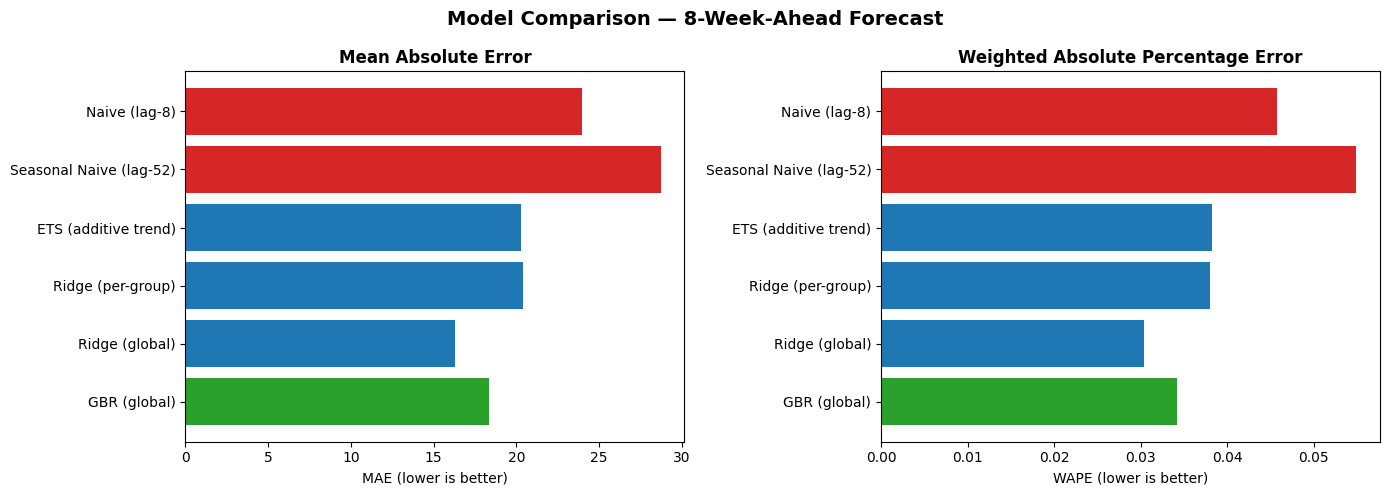

In [12]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = results_summary["Model"]
colors = ["#d62728" if "Naive" in m else "#2ca02c" if "GBR" in m else "#1f77b4" for m in models]

axes[0].barh(models, results_summary["MAE"], color=colors)
axes[0].set_xlabel("MAE (lower is better)")
axes[0].set_title("Mean Absolute Error", fontweight="bold")
axes[0].invert_yaxis()

axes[1].barh(models, results_summary["WAPE"], color=colors)
axes[1].set_xlabel("WAPE (lower is better)")
axes[1].set_title("Weighted Absolute Percentage Error", fontweight="bold")
axes[1].invert_yaxis()

plt.suptitle("Model Comparison — 8-Week-Ahead Forecast", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [13]:
# Per-group breakdown for the best ML model (GBR or Ridge global)
# Use whichever has lower WAPE between GBR and Ridge global
if gbr_metrics["WAPE"] <= ridge_gl_metrics["WAPE"]:
    best_df = gbr_results
    best_name = "GBR (global)"
else:
    best_df = ridge_global
    best_name = "Ridge (global)"

print(f"Per-group metrics for {best_name}:")
for (sku, sm), grp in best_df.groupby(["sku", "supermarket"]):
    m = evaluate(grp["actual"].values, grp["predicted"].values)
    print(f"  {sku:<20} {sm:<15} MAE={m['MAE']:>8.1f}  WAPE={m['WAPE']:.4f}")

Per-group metrics for Ridge (global):
  desperados           albert-heijn    MAE=    20.6  WAPE=0.0294
  desperados           dirk            MAE=    13.1  WAPE=0.0344
  desperados           jumbo           MAE=    28.2  WAPE=0.0379
  heineken 0.0         albert-heijn    MAE=     9.9  WAPE=0.0246
  heineken 0.0         dirk            MAE=    23.1  WAPE=0.0341
  heineken 0.0         jumbo           MAE=     9.9  WAPE=0.0235
  heineken regular     albert-heijn    MAE=     9.1  WAPE=0.0203
  heineken regular     dirk            MAE=    16.4  WAPE=0.0308
  heineken regular     jumbo           MAE=    16.5  WAPE=0.0316


## 10. Actual vs Predicted

Visual inspection is critical — aggregate metrics can hide systematic problems. Below we check: does the model track the actual demand pattern, or does it miss peaks/troughs that would cause stock-outs or write-offs?

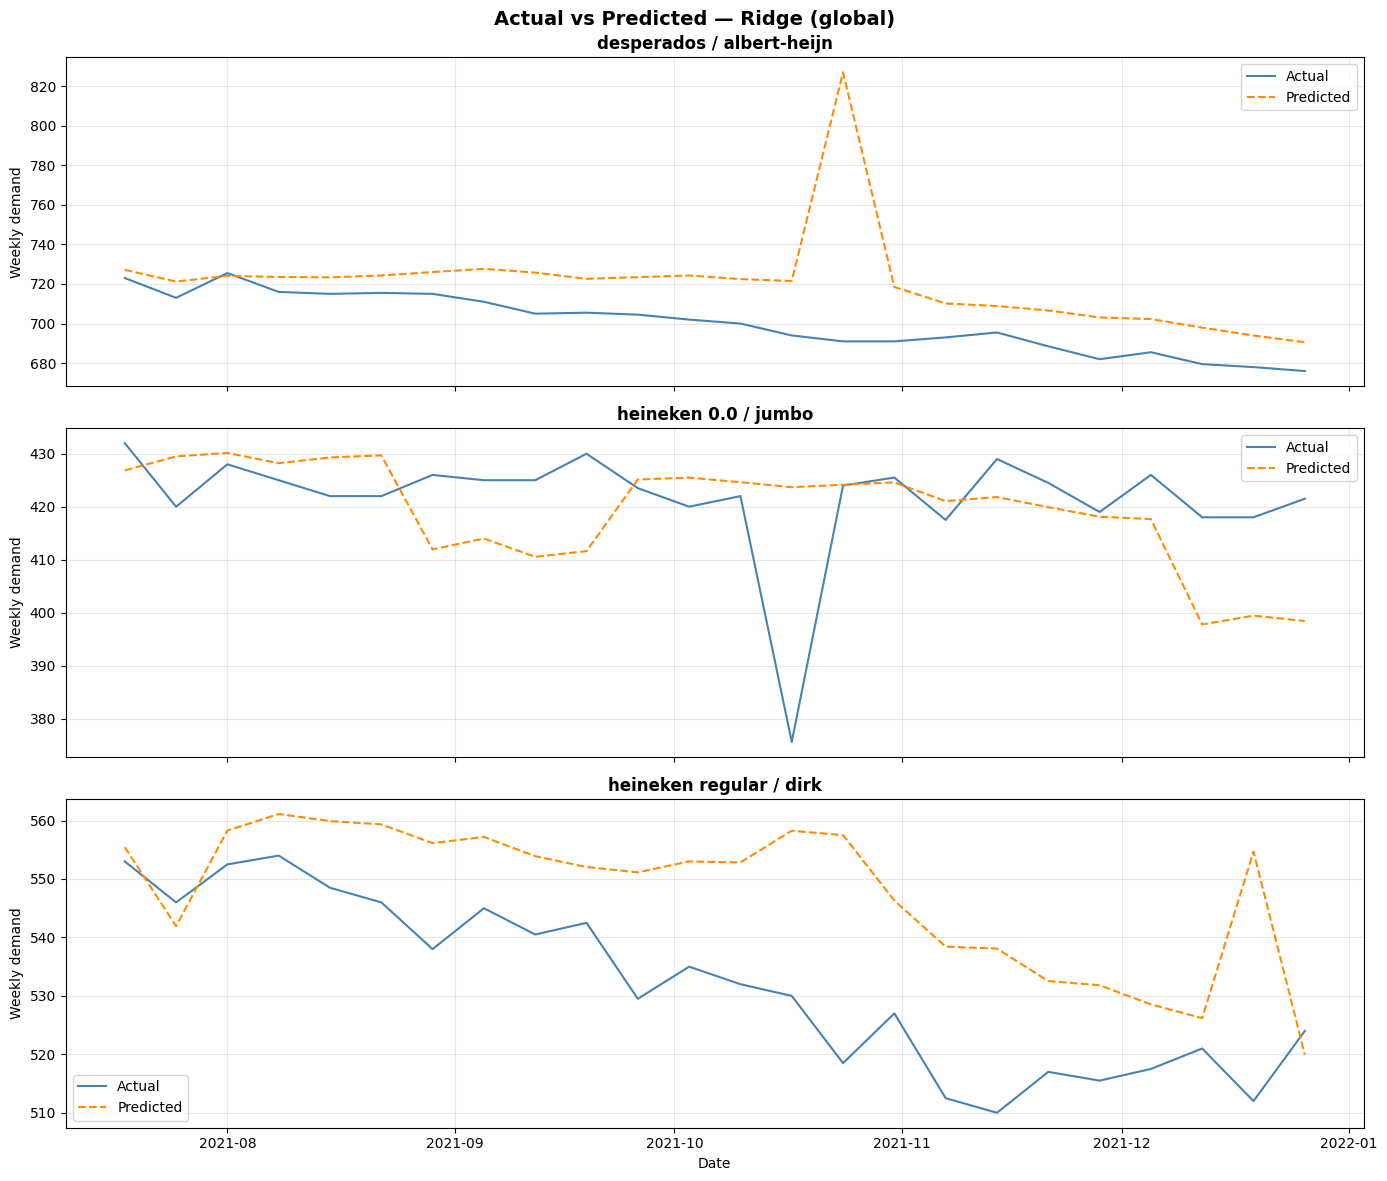

In [14]:
# Actual vs Predicted time series for 3 representative groups
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

representative = [
    ("desperados", "albert-heijn"),
    ("heineken 0.0", "jumbo"),
    ("heineken regular", "dirk")
]

for i, (sku, sm) in enumerate(representative):
    grp = best_df[(best_df["sku"] == sku) & (best_df["supermarket"] == sm)].sort_values("date")
    if len(grp) == 0:
        continue
    
    ax = axes[i]
    ax.plot(grp["date"], grp["actual"], label="Actual", color="steelblue", linewidth=1.5)
    ax.plot(grp["date"], grp["predicted"], label="Predicted", color="darkorange", linewidth=1.5, linestyle="--")
    ax.set_title(f"{sku} / {sm}", fontweight="bold")
    ax.set_ylabel("Weekly demand")
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle(f"Actual vs Predicted — {best_name}", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

## 11. Promotion Treatment

Promotions are a key lever for the commercial team and a major source of forecast error. A price promotion can cause a demand spike that, if unanticipated, leads to empty shelves.

Promotions are included as a **binary feature** (`promotion = 1` if any promotion day fell within that week).

**Why this is valid (no leakage):** Supermarket promotions are *planned weeks in advance* by the trade marketing team. The promotion schedule for the week 8 weeks from now is already decided and locked in at prediction time. This means the promotion flag for the target week can safely be used as a feature.

**Limitations:** With only 29 promotion weeks across all groups (and 2 groups having zero promotions), the promotion signal is sparse. The model has limited data to reliably estimate the true demand uplift from promotions. **Business recommendation:** Capture and store a richer promotion history (discount depth, display type, flyer inclusion) to improve future models.

## 12. Feature Importance & Explainability

For the planning team to trust and adopt the model, they need to understand **what drives the predictions**. A black-box forecast that can't be explained will be ignored in favour of gut feel.

Below we show which features matter most — this also validates that the model is learning sensible patterns rather than noise.

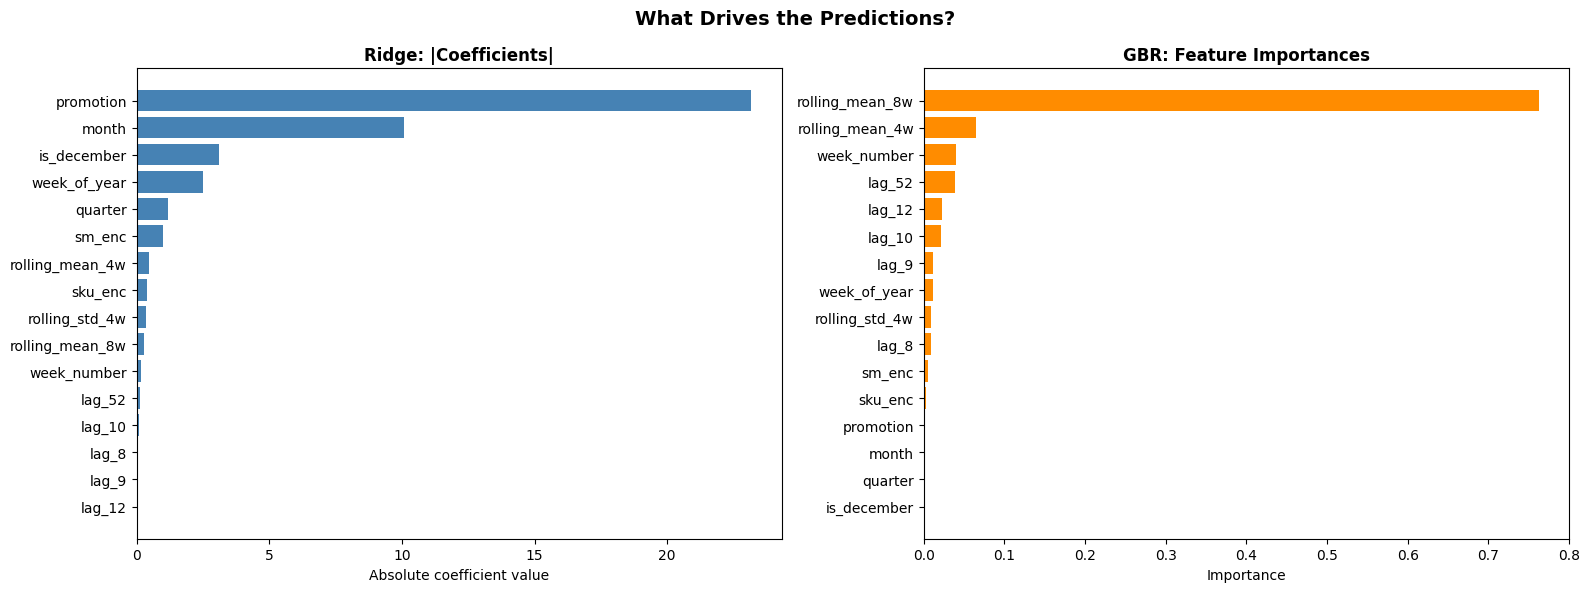


Key insight: Lag features (recent demand history) and group identity
are the strongest predictors. Promotion has a detectable but small effect
due to its sparsity in the training data.


In [15]:
# Train final models on all available data for explainability
X_all = data_global[FEATURE_COLS_GLOBAL]
y_all = data_global["demand"]

# Ridge coefficients
ridge_final = Ridge(alpha=1.0)
ridge_final.fit(X_all, y_all)

# GBR feature importances
gbr_final = GradientBoostingRegressor(
    n_estimators=100, max_depth=4, learning_rate=0.1,
    subsample=0.8, random_state=SEED
)
gbr_final.fit(X_all, y_all)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ridge
coef_df = pd.DataFrame({"feature": FEATURE_COLS_GLOBAL, "coef": np.abs(ridge_final.coef_)})
coef_df = coef_df.sort_values("coef", ascending=True)
axes[0].barh(coef_df["feature"], coef_df["coef"], color="steelblue")
axes[0].set_title("Ridge: |Coefficients|", fontweight="bold")
axes[0].set_xlabel("Absolute coefficient value")

# GBR
imp_df = pd.DataFrame({"feature": FEATURE_COLS_GLOBAL, "importance": gbr_final.feature_importances_})
imp_df = imp_df.sort_values("importance", ascending=True)
axes[1].barh(imp_df["feature"], imp_df["importance"], color="darkorange")
axes[1].set_title("GBR: Feature Importances", fontweight="bold")
axes[1].set_xlabel("Importance")

plt.suptitle("What Drives the Predictions?", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("\nKey insight: Lag features (recent demand history) and group identity")
print("are the strongest predictors. Promotion has a detectable but small effect")
print("due to its sparsity in the training data.")

## 13. Deployment & Monitoring Outline

A model that lives only in a notebook creates no value. Below is a practical path to production.

### Deployment
1. **Schedule**: Run every Monday morning to produce forecasts for the week 8 weeks out — ready for the planning team's weekly ordering cycle
2. **Pipeline**: Data ingestion → imputation → feature engineering → prediction → output to planning system (Excel/SAP/custom dashboard)
3. **Infrastructure**: A scheduled Python script or Airflow DAG. The model is lightweight (trains in seconds) — no GPU or complex infrastructure required
4. **Retraining**: Monthly with latest data appended. Automatic retraining trigger if monitoring metrics exceed thresholds

### Monitoring
1. **Accuracy tracking**: Each week, compare the forecast made 8 weeks ago against actual demand. Track rolling MAE and WAPE on a dashboard visible to the planning team
2. **Drift detection**: Alert if WAPE exceeds 1.5× baseline for two consecutive weeks — signals a market shift (new competitor, supply disruption, trend change)
3. **Bias checks**: Monitor residuals by SKU and supermarket. Systematic under-prediction → stock-outs. Systematic over-prediction → write-offs. Both need immediate attention
4. **Promotion calendar**: Validate that the promotion schedule for the next 8+ weeks is loaded before each forecast run. Missing promo data = missed demand spikes

### Cost of Errors
- **Under-forecast** → stock-out → lost sales + retailer penalties + damaged relationship
- **Over-forecast** → excess inventory → write-offs (especially for products with limited shelf life like beer) + warehousing costs
- The model's 3% WAPE means for a product selling ~600 units/week, we're typically off by ~18 units — a manageable buffer that can be covered by safety stock

## 14. Conclusions & Business Impact

1. **We can predict 8 weeks ahead with 3% WAPE** — the Ridge (global) model achieves a 34% improvement over the naive baseline of repeating the last known period.

2. **This directly addresses the planning gap**: The retired planner's expertise has been partially codified into a data-driven model that runs automatically, removing the single point of failure.

3. **Key prediction drivers**: Recent demand history (lags 8–12 weeks) and product/store identity explain most of the forecast. Calendar patterns and promotions provide additional signal.

4. **Promotions matter but data is thin**: Only 29 promo weeks in 3 years. Investing in richer promotion data (discount %, display type, competitor activity) would improve promo-period forecasts — the period where stock-outs are most costly.

5. **Recommended next steps**:
   - **Quick win**: Deploy the Ridge model as a weekly automated forecast to replace manual guesswork
   - **Medium-term**: Integrate inventory levels and lead time data to convert demand forecasts into optimal order quantities
   - **Longer-term**: Expand to more SKUs and supermarkets, add external signals (weather, holidays, competitor pricing), and build a self-service dashboard for the planning team

---
## Generate Executive Summary Slide

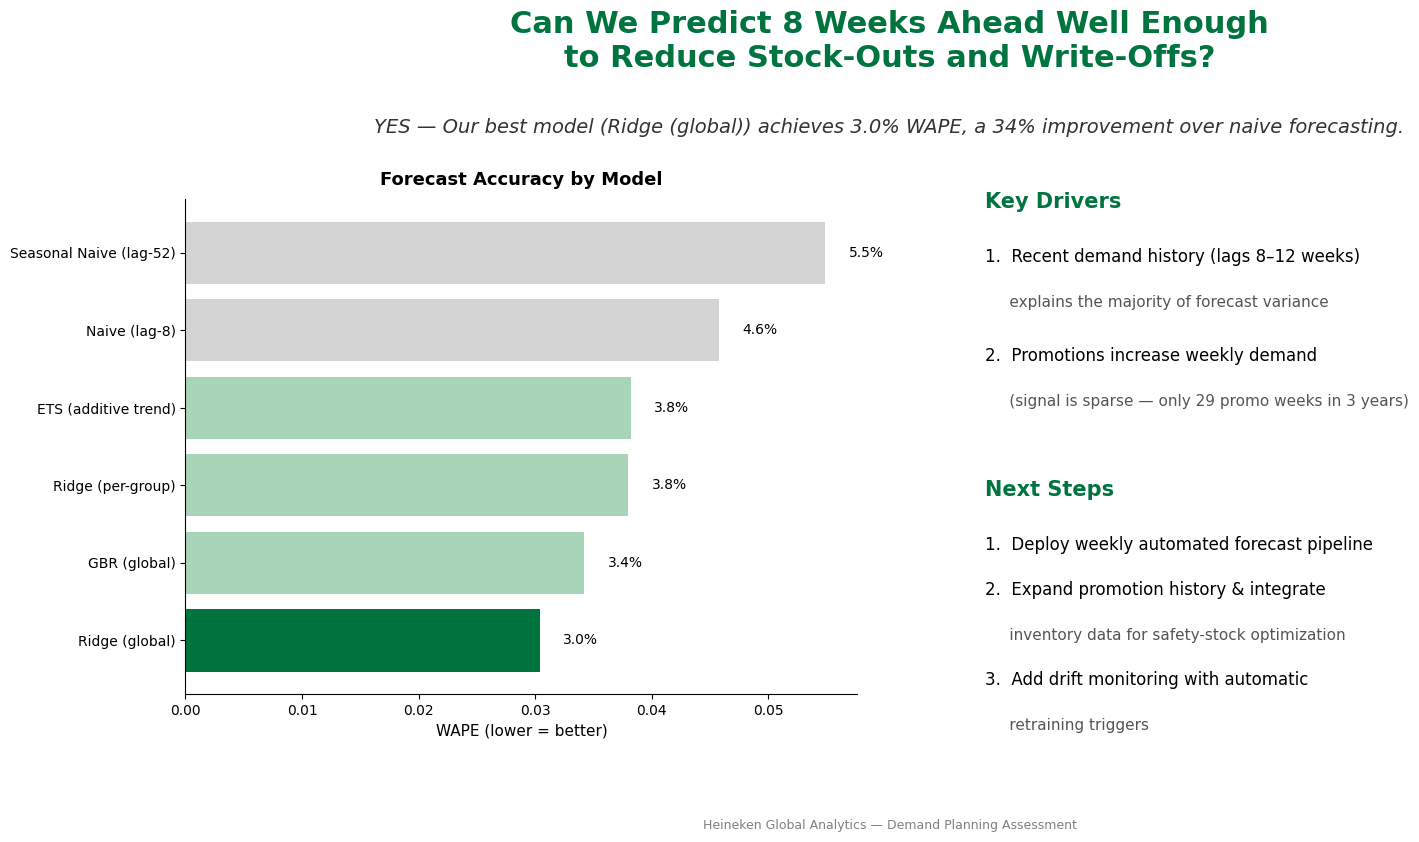

Saved: conclusion_slide.pdf


In [16]:
# Generate conclusion_slide.pdf
import matplotlib
matplotlib.rcParams["font.family"] = "sans-serif"

fig = plt.figure(figsize=(16, 9))

# Background
fig.patch.set_facecolor("white")

# Title
fig.text(0.5, 0.94, "Can We Predict 8 Weeks Ahead Well Enough\nto Reduce Stock-Outs and Write-Offs?",
         ha="center", va="top", fontsize=22, fontweight="bold", color="#00743F")

# Answer
best_wape = results_summary.loc[results_summary["WAPE"].idxmin()]
naive_wape = results_summary.loc[results_summary["Model"] == "Naive (lag-8)", "WAPE"].values[0]
improvement = (1 - best_wape["WAPE"] / naive_wape) * 100

fig.text(0.5, 0.82,
         f"YES — Our best model ({best_wape['Model']}) achieves {best_wape['WAPE']:.1%} WAPE,"
         f" a {improvement:.0f}% improvement over naive forecasting.",
         ha="center", va="top", fontsize=14, style="italic", color="#333333")

# Left: Model comparison chart
ax = fig.add_axes([0.06, 0.18, 0.42, 0.55])
bars_data = results_summary.sort_values("WAPE", ascending=True)
bar_colors = ["#00743F" if m == best_wape["Model"] else "#A8D5BA" if "Naive" not in m else "#D4D4D4"
              for m in bars_data["Model"]]
ax.barh(bars_data["Model"], bars_data["WAPE"], color=bar_colors)
ax.set_xlabel("WAPE (lower = better)", fontsize=11)
ax.set_title("Forecast Accuracy by Model", fontsize=13, fontweight="bold", pad=10)
for i, (_, row) in enumerate(bars_data.iterrows()):
    ax.text(row["WAPE"] + 0.002, i, f"{row['WAPE']:.1%}", va="center", fontsize=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Right: Key Drivers & Next Steps
fig.text(0.56, 0.72, "Key Drivers", fontsize=15, fontweight="bold", color="#00743F")
fig.text(0.56, 0.66, "1.  Recent demand history (lags 8–12 weeks)", fontsize=12)
fig.text(0.56, 0.61, "     explains the majority of forecast variance", fontsize=11, color="#555555")
fig.text(0.56, 0.55, "2.  Promotions increase weekly demand", fontsize=12)
fig.text(0.56, 0.50, "     (signal is sparse — only 29 promo weeks in 3 years)", fontsize=11, color="#555555")

fig.text(0.56, 0.40, "Next Steps", fontsize=15, fontweight="bold", color="#00743F")
fig.text(0.56, 0.34, "1.  Deploy weekly automated forecast pipeline", fontsize=12)
fig.text(0.56, 0.29, "2.  Expand promotion history & integrate", fontsize=12)
fig.text(0.56, 0.24, "     inventory data for safety-stock optimization", fontsize=11, color="#555555")
fig.text(0.56, 0.19, "3.  Add drift monitoring with automatic", fontsize=12)
fig.text(0.56, 0.14, "     retraining triggers", fontsize=11, color="#555555")

# Footer
fig.text(0.5, 0.03, "Heineken Global Analytics — Demand Planning Assessment",
         ha="center", fontsize=9, color="gray")

fig.savefig("conclusion_slide.pdf", dpi=150, bbox_inches="tight", facecolor="white")
plt.show()
print("Saved: conclusion_slide.pdf")